### Jack's Car Rental (from Sutton and Barto)

In [3]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

max_num_cars = 10
max_cars_movable = 5
num_states = (max_num_cars+1)**2
num_actions = 2*max_cars_movable + 1 

move_price = 2
rent_price = 10

actions = np.arange(-max_cars_movable,max_cars_movable+1,1)
rewards = np.arange(-max_cars_movable*move_price,2*max_num_cars*rent_price+1,move_price)
num_possible_rewards = rewards.shape[0]

lambda_request = np.array([3,4])
lambda_return = np.array([3,2])

@njit
def factorial(n):
    fac = 1
    for i in range(1,n+1):
        fac *= i
    return fac

@njit
def p_exp(l,n):
    return l**n*np.exp(-l)/factorial(n)    

@njit
def p_exp_cumulative(l,n):
    p = 0
    for i in range(n):
        p += p_exp(l,i)
    return 1-p

@njit
def p(ss,r,s,a,verbose=False):
    r = int(r)
    a = int(a)
    rplus = r + move_price*np.abs(a)
    
    if np.abs(a)>max_cars_movable:
        return 0.0
    if np.any(ss<0) or np.any(ss>max_num_cars) or np.any(s<0) or np.any(s>max_num_cars):
        return 0.0
    if np.abs(rplus)%rent_price!=0 or rplus<0 or rplus>max_num_cars*2*rent_price:
        return 0.0
    
    action = np.array([-1,1])
    for i in range(2):    
        news = s[i] + action[i]*a
        if news<0:
            s[i] = 0
        elif news>max_num_cars:
            s[i] = max_num_cars
        else:
            s[i] = news
        
    num_cars_rented = np.abs(rplus)//rent_price
    
    if verbose:
        print("Number of cars rented = ",num_cars_rented)
        print("Target = ",ss)
        print("State in morning = ",s)
        print("Beginning loop...")
    
    p = 0
    for ra in range(0,num_cars_rented+1):
        rb = num_cars_rented-ra
        oa = ss[0]-s[0]+ra
        ob = ss[1]-s[1]+rb
        
        if verbose:
            print("Number of cars to be rented at each loc = ",ra,rb)
            print("Number of cars to be returned = ",oa,ob)
            
        if oa<0 or ob<0:
            if verbose:
                print("Avoided because number of cars is lower than after rental")
            continue
            
            
        if ra<s[0]:
            if oa<max_num_cars and ss[0]!=max_num_cars:
                pa = p_exp(lambda_request[0],ra)*p_exp(lambda_return[0],oa)
            elif oa==max_num_cars or ss[0]==max_num_cars:
                pa = p_exp(lambda_request[0],ra)*p_exp_cumulative(lambda_return[0],oa)
        elif ra==s[0]:
            if oa<max_num_cars and ss[0]!=max_num_cars:
                pa = p_exp_cumulative(lambda_request[0],ra)*p_exp(lambda_return[0],oa)
            elif oa==max_num_cars or ss[0]==max_num_cars:
                pa = p_exp_cumulative(lambda_request[0],ra)*p_exp_cumulative(lambda_return[0],oa)
        else:
            if verbose:
                print("Not enough cars at A")
            continue
                
                
        if rb<s[1]:
            if ob<max_num_cars and ss[1]!=max_num_cars:
                pb = p_exp(lambda_request[1],rb)*p_exp(lambda_return[1],ob)
            elif ob==max_num_cars or ss[1]==max_num_cars:
                pb = p_exp(lambda_request[1],rb)*p_exp_cumulative(lambda_return[1],ob)
        elif rb==s[1]:
            if ob<max_num_cars and ss[1]!=max_num_cars:
                pb = p_exp_cumulative(lambda_request[1],rb)*p_exp(lambda_return[1],ob)
            elif ob==max_num_cars or ss[1]==max_num_cars:
                pb = p_exp_cumulative(lambda_request[1],rb)*p_exp_cumulative(lambda_return[1],ob)
        else:
            if verbose:
                print("Not enough cars at B")
            continue
        
        p += pa*pb
    
    return p


@njit
def state2int(state):
    return state[0]*(max_num_cars+1) + state[1]

@njit
def int2state(i):
    return np.array([i%(max_num_cars+1),i//(max_num_cars+1)])
    
@njit
def buildDynamicTab(verbose=False):
    
    ptab = np.zeros((num_states,num_possible_rewards,num_actions,num_states))
    
    for r_ind,r in enumerate(rewards):
        if verbose:
            print(r_ind)
        for ss in range(num_states):
            for s in range(num_states):
                for a_ind, a in enumerate(actions):
                    ptab[ss,r_ind,a_ind,s] = p(int2state(ss),r,int2state(s),a)
    return ptab
    

In [4]:
ptab = buildDynamicTab()

In [5]:
def update_values(v,pi,ptab,rewards,gamma=0.9):
    return np.einsum('nrao,nr->o',ptab*pi[np.newaxis,np.newaxis,:,:],gamma*v[:,np.newaxis]+rewards[np.newaxis,:])

def policy_evaluation(v,pi,ptab,rewards,max_iterations=100,eps=0.1):
    
    v_new = update_values(v,pi,ptab,rewards)
    i = 0
    while np.max(np.abs(v_new-v))>eps:
        v = v_new[:]
        v_new = update_values(v,pi,ptab,rewards)
        i += 1
        if i>max_iterations:
            print("Didn't converge")
            break
    if np.max(np.abs(v_new-v))<eps:
        print("Evaluation converged at iteration ",i)
        
    return v

def update_q(v,pi,ptab,rewards,gamma=0.9):
    return np.einsum('nrao,nr->ao',ptab,gamma*v[:,np.newaxis]+rewards[np.newaxis,:])

def update_policy(v,pi,ptab,rewards,gamma=0.9):
    q = update_q(v,pi,ptab,rewards,gamma=0.9)
    pi_new = np.zeros((num_actions,num_states))
    new_actions = np.argmax(q,axis=0)
    
    for s,a in enumerate(new_actions):
        pi_new[a,s] = 1.0
        
    return pi_new
    
def policy_iteration(v,pi,ptab,rewards,gamma=0.9,max_iterations=1000,verbose=True):
    
    pi = np.zeros((num_actions,num_states))
    for i in range(num_states):
        j = np.random.choice(num_actions)
        pi[j,i] = 1.0
        
    v = policy_evaluation(v,pi,ptab,rewards,max_iterations=100,eps=0.1)
    pi_new = update_policy(v,pi,ptab,rewards,gamma=0.9)
    
    i = 0
    
    while np.any(pi_new!=pi):
        if verbose:
            print("Iteration : ",i)
        pi = pi_new[:,:]
        v = policy_evaluation(v,pi,ptab,rewards,max_iterations=100,eps=0.1)
        pi_new = update_policy(v,pi,ptab,rewards,gamma=0.9)
        i += 1
        if i>max_iterations:
            print("Didn't converge")
            break
            
    if np.all(pi_new!=pi):
        print('Converged at iteration ', i)
        
    return pi_new
    

In [6]:
np.random.seed(30)
v = np.random.rand(num_states)
pi = np.zeros((num_actions,num_states))

pi = policy_iteration(v,pi,ptab,rewards,gamma=0.9,max_iterations=100)

Evaluation converged at iteration  58
Iteration :  0
Evaluation converged at iteration  44
Iteration :  1
Evaluation converged at iteration  7
Iteration :  2
Evaluation converged at iteration  1


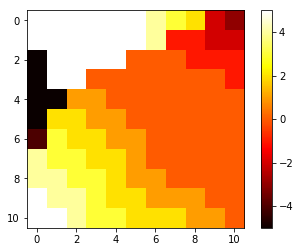

In [7]:
pi_asmat = np.zeros((max_num_cars+1,max_num_cars+1))
for n in range(num_states):
    a,b = int2state(n)
    pi_asmat[a,b] = actions[np.argwhere(pi[:,n]!=0)[0,0]]
    
plt.imshow(pi_asmat, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()